In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

### Model

In [2]:
np.random.seed(1234)

In [3]:
%%capture --no-display

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Building Image Folders

In [5]:
pkm_path = '../data/pokemon_types.csv'
pkm_img_path = '../data/images'

pkm = pd.read_csv(pkm_path)
pkm.head(3)

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison


In [6]:
X_train, X_test, y_train, y_test = train_test_split(pkm['Name'], pkm['Type1'], test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [7]:
for df in [X_train, y_train, X_val, y_val, X_test, y_test]:
    print(len(df), end = '\n')

517
517
130
130
162
162


In [8]:
def image_keras_creator(pkm_img_path, new_dir):
    os.mkdir(new_dir)
    
    for d in ['train', 'test', 'validation']:
        folder = new_dir + '/' + d
        os.mkdir(folder)
        
        for t in pkm['Type1'].unique():
            type_folder = folder + '/' + t
            os.mkdir(type_folder)
            
    residual = []
    
    for img in os.listdir(pkm_img_path):
        if '.png' in img:
            pkm_name = img.replace('.png', '')
        elif ',jpg' in img:
            pkm_name = img.replace('jpg', '')
            
        if pkm_name not in pkm['Name'].to_numpy():
            residual.append(img)
            continue
        file_path = pkm_img_path + '/' + img
        
        if pkm_name in X_train.to_numpy():
            new_file = new_dir + '/' + 'train' + '/' + \
                pkm.loc[pkm['Name'] == pkm_name, 'Type1'].to_numpy()[0] + '/' + img
            shutil.copy2(file_path, new_file)
            
        if pkm_name in X_val.to_numpy():
            new_file = new_dir + '/' + 'validation' + '/' + \
                pkm.loc[pkm['Name'] == pkm_name, 'Type1'].to_numpy()[0] + '/' + img
            shutil.copy2(file_path, new_file)
            
        if pkm_name in X_test.to_numpy():
            new_file = new_dir + '/' + 'test' + '/' + \
                pkm.loc[pkm['Name'] == pkm_name, 'Type1'].to_numpy()[0] + '/' + img
            shutil.copy2(file_path, new_file)
            
    print('Unused:', residual, '\n')
        
        
        

In [ ]:
new_dir = '../data/pokemon_image_keras'

image_keras_creator(pkm_img_path, new_dir)

Unused: [] 



### Data Preprocessing

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    directory = new_dir + '/' + 'train',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

Found 502 images belonging to 18 classes.


In [15]:
validation_generator = validation_datagen.flow_from_directory(
    directory = new_dir + '/' + 'validation',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

Found 135 images belonging to 18 classes.


In [16]:
%%capture --no-display

for data_batch, labels_batch in train_generator:
    print(data_batch.shape, "\n")
    print(labels_batch.shape, "\n")
    break

### Callbacks

In [17]:
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

In [18]:
csv_logger = CSVLogger('../output/logs/training.log',
                       separator = ',',
                       append = False)

### Fitting the Model

In [19]:
models_folder = '../output/models'

In [20]:
%%capture --no-display

history = model.fit(
    train_generator,
    steps_per_epoch = 52,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 13,
    callbacks = [earlystop, csv_logger]
)  

In [21]:
model.save(models_folder + '/CNN_01.keras')

### Plot the Accuracy of the Model

In [22]:
%matplotlib inline

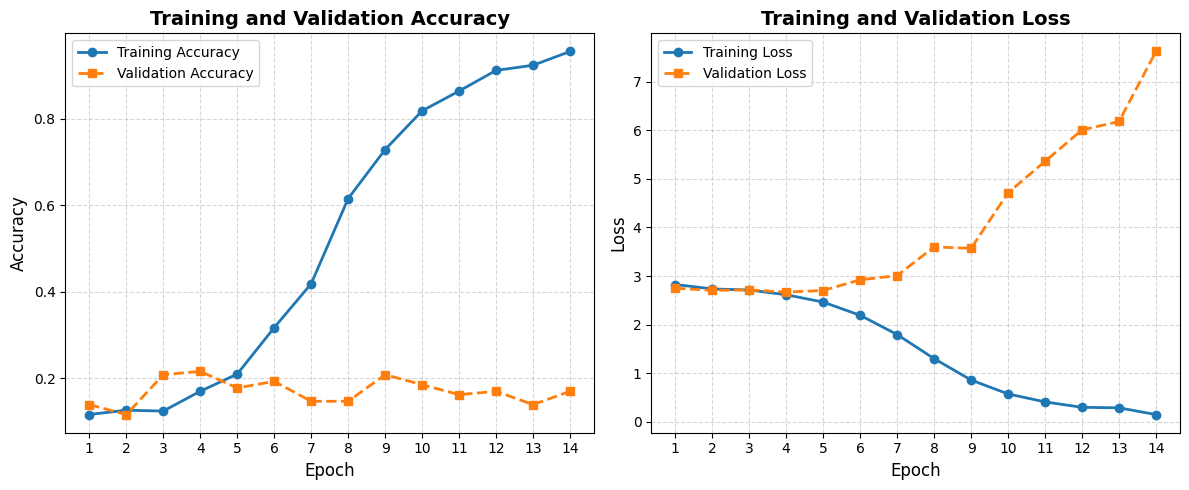

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
log_data = pd.read_csv('../output/logs/training.log', sep = ',', engine = 'python')
log_data

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.115538,2.825248,0.138462,2.747850
1,1,0.125498,2.734277,0.115385,2.705086
2,2,0.123506,2.712264,0.207692,2.713257
3,3,0.169323,2.614942,0.215385,2.670255
4,4,0.209163,2.463283,0.176923,2.701750
5,5,0.316733,2.191551,0.192308,2.923118
6,6,0.418327,1.795215,0.146154,3.007988
7,7,0.615538,1.299087,0.146154,3.599878
8,8,0.729084,0.858529,0.207692,3.569667
9,9,0.818725,0.572350,0.184615,4.713617


Overfitting is evident.

Indeed, we have very few samples (517) and many categories (18). So we try using data augmentation.

In [25]:
datagen = ImageDataGenerator(
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

In [26]:
#choose an image of a training water-type pokemon
d = new_dir + '/' + 'train' + '/' + 'Water'
names = [os.path.join(d, name) for name in os.listdir(d)]
name = np.random.choice(names)

PNG
(120, 120)
RGBA
uint8
(120, 120, 4)


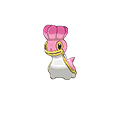

In [93]:
#Method 1
from PIL import Image

img = Image.open(name)
print(img.format)
print(img.size)
print(img.mode)
print(np.asarray(img).dtype) 
print(np.asarray(img).shape)
img

float32
(120, 120, 4)


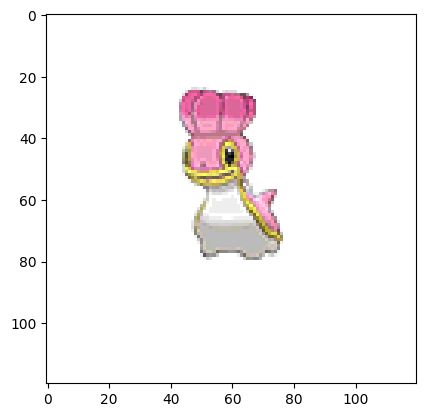

In [ ]:
#Method 2
img = plt.imread(name)
print(img.dtype)
print(img.shape)
plt.imshow(img)
plt.show()

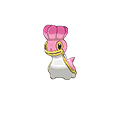

In [96]:
#Method 3
from keras.utils import load_img

img = load_img(name, color_mode = 'rgba', target_size = (120, 120))
#Returns PIL Image instance
img

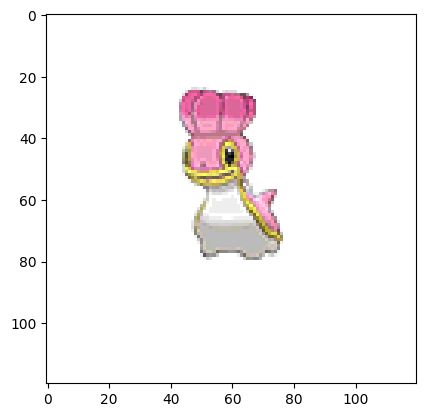

In [98]:
plt.imshow(img)
plt.show()

(120, 120, 4)


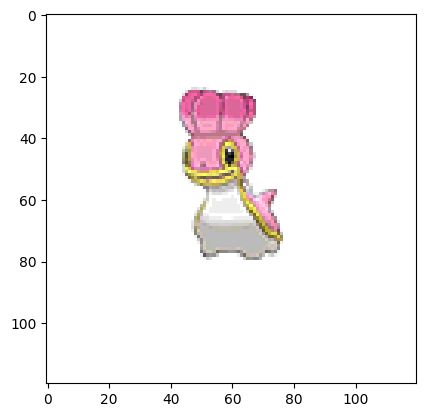

In [100]:
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.show()

In [104]:
img = img[np.newaxis, ...]

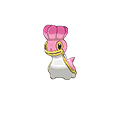

In [ ]:
from tensorflow.keras.utils import array_to_img
array_to_img(img[0])

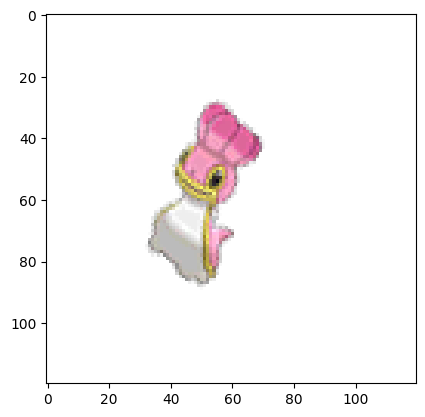

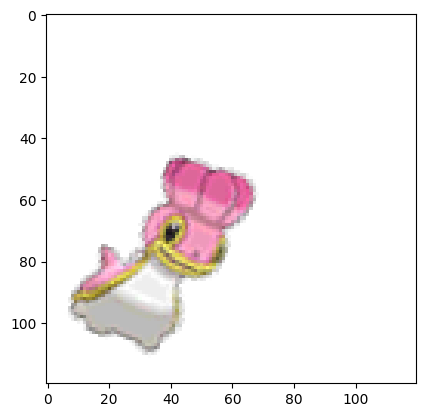

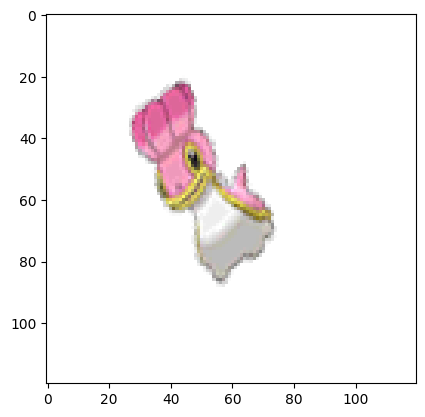

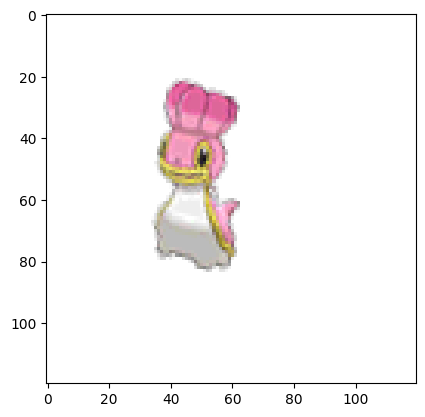

In [108]:
i = 0

for batch in datagen.flow(img, batch_size = 1):
    plt.figure(i)
    b = batch[0]
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i == 4:
        break

plt.show()

To further reduce overfit we add a Dropout layer to our model:

In [29]:
%%capture --no-display

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# The validation data should not be augmented.
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = new_dir + '/' + 'train',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
        directory = new_dir + '/' + 'validation',
        target_size = (120, 120),
        batch_size = 10,
        class_mode = 'categorical')

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 20,
    verbose = 1,
    mode = 'auto'
)

csv_logger = CSVLogger('../output/logs/training_augmented.log',
                       separator=',', 
                       append=False)



In [31]:
%%capture --no-display

history = model.fit(
      train_generator,
      steps_per_epoch=52,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=13,
      callbacks=[earlystop, csv_logger])

In [32]:
model.save(models_folder + '/CNN_02.keras')

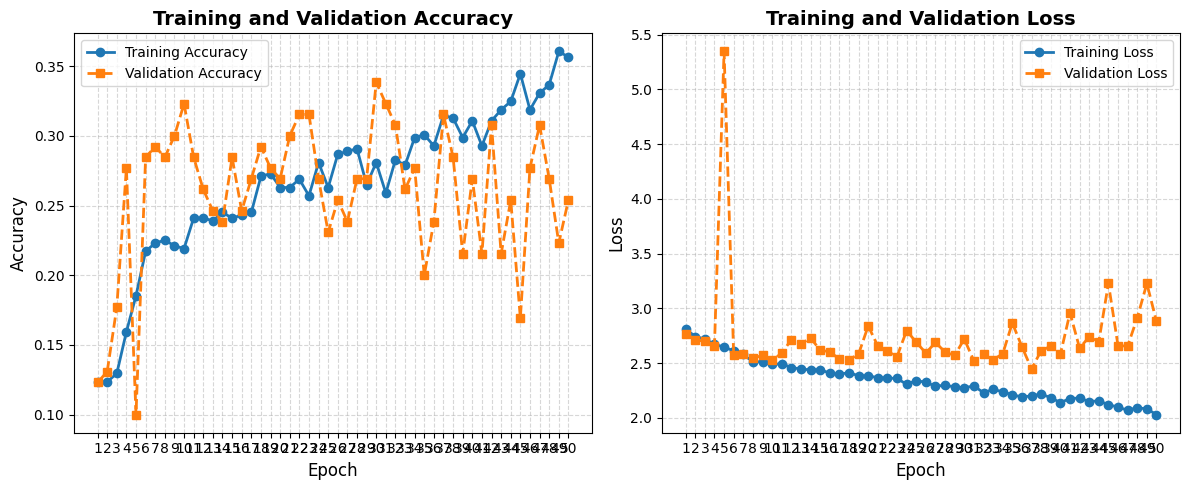

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory = new_dir + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

Found 172 images belonging to 18 classes.


In [35]:
%%capture --no-display

test_loss, test_acc = model.evaluate(test_generator)

In [36]:
test_acc

0.29651162028312683

In [37]:
pred_generator = test_datagen.flow_from_directory(
    directory = new_dir + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode=None,  # only data, no labels
    shuffle=False)  # keep data in same order as labels

Found 172 images belonging to 18 classes.


In [38]:
%%capture --no-display

preds = model.predict(pred_generator)

In [39]:
pred_generator.class_indices

{'Bug': 0,
 'Dark': 1,
 'Dragon': 2,
 'Electric': 3,
 'Fairy': 4,
 'Fighting': 5,
 'Fire': 6,
 'Flying': 7,
 'Ghost': 8,
 'Grass': 9,
 'Ground': 10,
 'Ice': 11,
 'Normal': 12,
 'Poison': 13,
 'Psychic': 14,
 'Rock': 15,
 'Steel': 16,
 'Water': 17}

In [40]:
classes = list(pred_generator.class_indices.keys())
classes

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

In [41]:
preds.shape

(172, 18)

In [42]:
pred_values = preds.argmax(axis = 1)
pred_values

array([ 1, 14,  0, 12,  0,  0, 17,  0,  0,  8,  0,  0,  0,  0,  3,  1,  1,
        1,  1,  1,  1,  6,  6, 14,  1,  1, 13, 14,  3,  4,  0, 14,  0,  0,
        3, 12, 14, 12,  1,  3, 12, 12, 13, 14, 13,  0, 12,  6,  6,  3,  0,
        6,  6,  0,  0,  6,  3,  6,  6,  6, 12, 12, 14, 17, 13,  9,  8,  9,
       17,  9,  9,  0, 12,  9,  9,  0, 13,  0, 14,  2,  6,  0,  9,  9,  6,
       13, 12,  3, 17, 12,  9, 13, 17, 16, 16, 14, 12, 14, 13, 12, 14, 12,
       12, 13, 12,  6,  0,  1, 12, 12, 12,  4, 12, 12, 13, 13,  3, 12, 13,
       14,  1, 14,  3,  2, 17, 13, 14, 13, 17,  8,  3,  4,  0,  2,  2, 17,
       17, 17,  9,  0,  0, 17, 17,  0, 14, 14,  3,  6, 12, 17, 12, 14,  9,
       12,  6, 17, 13, 17, 13,  8, 13, 12, 17, 13,  4,  1,  1,  3, 12, 17,
       17, 17])

In [43]:
preds_labels = np.array(classes)[pred_values]
preds_labels

array(['Dark', 'Psychic', 'Bug', 'Normal', 'Bug', 'Bug', 'Water', 'Bug',
       'Bug', 'Ghost', 'Bug', 'Bug', 'Bug', 'Bug', 'Electric', 'Dark',
       'Dark', 'Dark', 'Dark', 'Dark', 'Dark', 'Fire', 'Fire', 'Psychic',
       'Dark', 'Dark', 'Poison', 'Psychic', 'Electric', 'Fairy', 'Bug',
       'Psychic', 'Bug', 'Bug', 'Electric', 'Normal', 'Psychic', 'Normal',
       'Dark', 'Electric', 'Normal', 'Normal', 'Poison', 'Psychic',
       'Poison', 'Bug', 'Normal', 'Fire', 'Fire', 'Electric', 'Bug',
       'Fire', 'Fire', 'Bug', 'Bug', 'Fire', 'Electric', 'Fire', 'Fire',
       'Fire', 'Normal', 'Normal', 'Psychic', 'Water', 'Poison', 'Grass',
       'Ghost', 'Grass', 'Water', 'Grass', 'Grass', 'Bug', 'Normal',
       'Grass', 'Grass', 'Bug', 'Poison', 'Bug', 'Psychic', 'Dragon',
       'Fire', 'Bug', 'Grass', 'Grass', 'Fire', 'Poison', 'Normal',
       'Electric', 'Water', 'Normal', 'Grass', 'Poison', 'Water', 'Steel',
       'Steel', 'Psychic', 'Normal', 'Psychic', 'Poison', 'Normal',
 

In [44]:
pred_generator.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int32)

In [45]:
true_values = pred_generator.classes
true_values

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int32)

In [46]:
true_labels = np.array(classes)[true_values]
true_labels

array(['Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug',
       'Bug', 'Bug', 'Bug', 'Bug', 'Dark', 'Dark', 'Dark', 'Dark', 'Dark',
       'Dark', 'Dark', 'Dark', 'Dragon', 'Dragon', 'Dragon', 'Dragon',
       'Dragon', 'Dragon', 'Electric', 'Electric', 'Electric', 'Electric',
       'Electric', 'Electric', 'Electric', 'Electric', 'Electric',
       'Electric', 'Fairy', 'Fairy', 'Fairy', 'Fighting', 'Fighting',
       'Fighting', 'Fighting', 'Fighting', 'Fighting', 'Fire', 'Fire',
       'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire',
       'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Ghost', 'Ghost',
       'Ghost', 'Ghost', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Ground', 'Ground',
       'Ground', 'Ground', 'Ground', 'Ground', 'Ground', 'Ground', 'Ice',
       'Ice', 'Ice', 'Ice', 'Ice', 'Ice', 'Ice', 'Normal', 'Normal',
  

In [47]:
res = pd.DataFrame({'true':true_labels, 'predicted':preds_labels})

res.head()

,true,predicted
0,Bug,Dark
1,Bug,Psychic
2,Bug,Bug
3,Bug,Normal
4,Bug,Bug


In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
cm = confusion_matrix(true_values, pred_values)
print(cm)

[[ 8  1  0  0  0  0  0  1  0  0  0  1  0  1  0  0  1]
 [ 1  6  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  2  0  0  0  0  0  1  1  0  0  0]
 [ 3  0  0  2  1  0  0  0  0  0  0  1  0  3  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  2  2  1  0  0  0]
 [ 3  0  0  2  0  0  8  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1]
 [ 4  0  1  0  0  0  1  1  6  0  0  1  1  1  0  0  1]
 [ 0  0  0  1  0  0  1  0  2  0  0  2  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  2  0  2  1]
 [ 1  1  0  1  1  0  1  0  0  0  0 10  4  1  0  0  0]
 [ 0  1  1  1  0  0  0  0  0  0  0  0  2  2  0  0  1]
 [ 1  0  2  1  1  0  0  1  0  0  0  0  1  1  0  0  3]
 [ 2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 1  2  0  2  1  0  2  1  1  0  0  5  4  3  0  0  8]]


In [50]:
pd.Series(classes)[np.invert(pd.Series(classes).isin(true_labels))]

7    Flying
dtype: object

There is no flying type in test data. So we remove it in showing the confusion matrix.

In [51]:
classes_corr = classes.copy()
classes_corr.remove('Flying')

In [52]:
df_cm = pd.DataFrame(cm, 
                     index = [c for c in classes_corr],
                     columns = [c for c in classes_corr])
df_cm

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Bug,8,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1
Dark,1,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Dragon,0,2,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0
Electric,3,0,0,2,1,0,0,0,0,0,0,1,0,3,0,0,0
Fairy,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
Fighting,1,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0
Fire,3,0,0,2,0,0,8,0,0,0,0,3,0,0,0,0,0
Ghost,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
Grass,4,0,1,0,0,0,1,1,6,0,0,1,1,1,0,0,1
Ground,0,0,0,1,0,0,1,0,2,0,0,2,1,0,0,0,1


<Axes: >

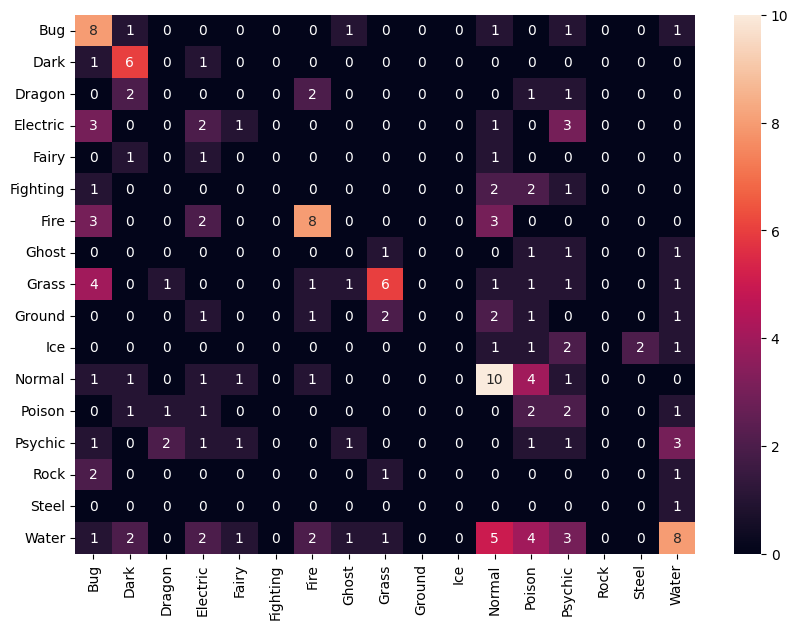

In [53]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

I should divide train, validation and test data by randomly splitting in each type category proportional to the relative sizes of the 3 datasets.
Also, I change the size proportion of the 3 sets by dividing in a different way.

I also rerun the model to reset the weights.

In [54]:
%%capture --no-display

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
X_train, X_rem, y_train, y_rem = train_test_split(pkm['Name'], pkm['Type1'], 
                                                  test_size = 400, random_state = 1234,
                                                  stratify = pkm['Type1']) 
#I had to choose almost 0.5 to avoid error for too few class instances (I think the problem is the flying type)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, 
                                                test_size = 0.5, random_state = 1234,
                                                stratify = y_rem)

for df in [X_train, y_train, X_val, y_val, X_test, y_test]:
    print(len(df), end = '\n')

409
409
200
200
200
200


In [ ]:
new_dir2 = '../data/pokemon_image_keras_2'

image_keras_creator(pkm_img_path, new_dir2)

In [58]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = new_dir2 + '/' + 'train',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
        directory = new_dir2 + '/' + 'validation',
        target_size = (120, 120),
        batch_size = 10,
        class_mode = 'categorical')

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 20,
    verbose = 1,
    mode = 'auto'
)

csv_logger = CSVLogger('../output/logs/training_augmented.log',
                       separator=',', 
                       append=False)


Found 415 images belonging to 18 classes.
Found 205 images belonging to 18 classes.


In [59]:
%%capture --no-display

history = model.fit(
      train_generator,
      steps_per_epoch = 41,
      epochs = 100,
      validation_data = validation_generator,
      validation_steps = 20,
      callbacks = [earlystop, csv_logger])

In [60]:
model.save(models_folder + '/CNN_03.keras')

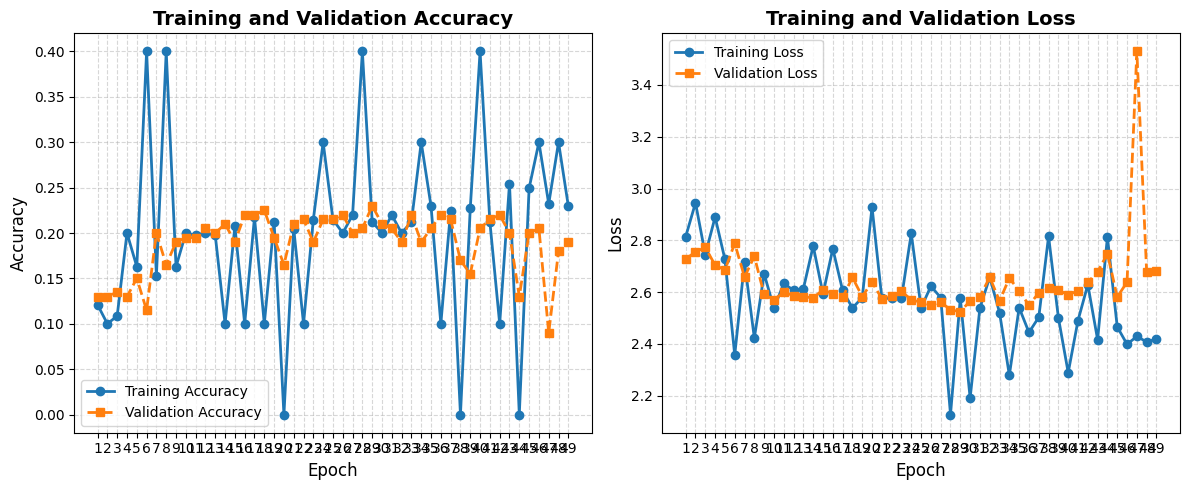

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()

Type stratification was good. 

However, before I test on test data, I should train the model with also validation data, as follows.

In [62]:
%%capture --no-display

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=41,
      epochs=60)

history = model.fit(
      validation_generator,
      steps_per_epoch=20,
      epochs=60)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.save(models_folder + '/CNN_04.keras')

In [64]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory = new_dir + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

test_loss, test_acc = model.evaluate(test_generator)

test_acc 

Found 172 images belonging to 18 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4153 - loss: 4.5296


0.38372093439102173

In [65]:
def cm_keras_generator(pred_generator):
    preds = model.predict(pred_generator)
    classes = list(pred_generator.class_indices.keys())
    pred_values = preds.argmax(axis = 1)
    preds_labels = np.array(classes)[pred_values]
    true_values = pred_generator.classes
    true_labels = np.array(classes)[true_values]
    res = pd.DataFrame({'true':true_labels, 'predicted':preds_labels})
    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm, 
                     index = [c for c in classes],
                     columns = [c for c in classes])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    return res, df_cm

In [66]:
pred_generator = test_datagen.flow_from_directory(
    directory = new_dir2 + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode=None,  # only data, no labels
    shuffle=False)  # keep data in same order as labels

Found 189 images belonging to 18 classes.


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


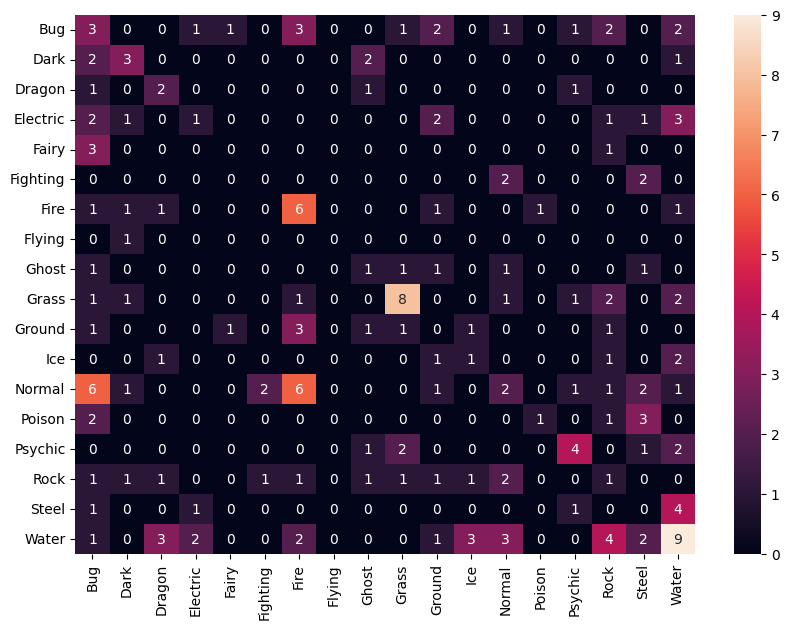

In [67]:
res, df_cm = cm_keras_generator(pred_generator)